In [2]:
import random
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['font.size'] = 24

import qiskit
from qiskit import Aer
from qiskit.ignis.measurement.discriminator.linear import LinearIQDiscriminationFitter
from qiskit.ignis.mitigation.measurement import circuits
from qiskit.result.models import ExperimentResultData

In [3]:
# Functions to make up some fake level 1 data for the qubits
# This could be replaced by Aer simulation once level 1 simulation
# Is available.
def qubit_shot(i0, q0, std):
    return [i0 + random.gauss(0, std), q0 + random.gauss(0, std)]

def create_shots(i0, q0, shots, qubits):
    """Creates data where all qubits are centered around i0 and q0"""
    data = []
    for ii in range(shots):
        shot = []
        for qbit in qubits:
            shot.append(qubit_shot(i0, q0, 0.1))
        data.append(shot)

    return data

## Prepare some test data for the discriminators

In [4]:
shots = 512
qubits = [0, 1]

meas_cal, state_labels = circuits.tensored_meas_cal([[0], [1]])

backend = Aer.get_backend('qasm_simulator')
job = qiskit.execute(meas_cal, backend=backend, shots=shots, meas_level=1)

cal_results = job.result()

i0, q0, i1, q1 = 0., -1., 0., 1.

# This will no longer be needed once Aer can do level 1.
ground = create_shots(i0, q0, shots, qubits)
excited = create_shots(i1, q1, shots, qubits)

cal_results.results[0].meas_level = 1
cal_results.results[1].meas_level = 1
cal_results.results[0].data = ExperimentResultData(memory=ground)
cal_results.results[1].data = ExperimentResultData(memory=excited)

discriminator_params = {'solver': 'svd'}

meas_cal[0].draw()

In [5]:
meas_cal[1].draw()

## Two-qubit discriminator

In [6]:
# Discriminator trained on boths qubits.
discriminator_2q = LinearIQDiscriminationFitter(cal_results,
                                             discriminator_params,
                                             qubits,
                                             ['cal_00', 'cal_11'],
                                             ['00', '11'])

# Examplify the Liniear discriminator
point1 = [i1, q1, i1, q1]
predicted1 = discriminator_2q.fit_fun.predict([point1])

point2 = [i0, q0, i0, q0]
predicted2 = discriminator_2q.fit_fun.predict([point2])

text = 'The IQ point ({},{},{},{}) correspnds to state {}.'
print(text.format(*point1, predicted1[0]))
print(text.format(*point2, predicted2[0]))

The IQ point (0.0,1.0,0.0,1.0) correspnds to state 11.
The IQ point (0.0,-1.0,0.0,-1.0) correspnds to state 00.


## Discrimination of a single qubit state

In [7]:
# Discriminator trained on the first qubit only.
qubit = 0

discriminator_1q = LinearIQDiscriminationFitter(cal_results,
                                             discriminator_params,
                                             [qubit],
                                             ['cal_00', 'cal_11'],
                                             ['0', '1'])

In [8]:
iq_range = 1.5*max(i0, q0, i1, q1)
spacing = 0.005
xx, yy = np.meshgrid(np.arange(-iq_range, iq_range, spacing), 
                     np.arange(-iq_range, iq_range, spacing))

Z = discriminator_1q.fit_fun.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.astype(float).reshape(xx.shape)

In [9]:
# Convert the data to something more usable.
from qiskit.result.postprocess import _list_to_complex_array
ground_shots = _list_to_complex_array(ground)
excited_shots = _list_to_complex_array(excited)

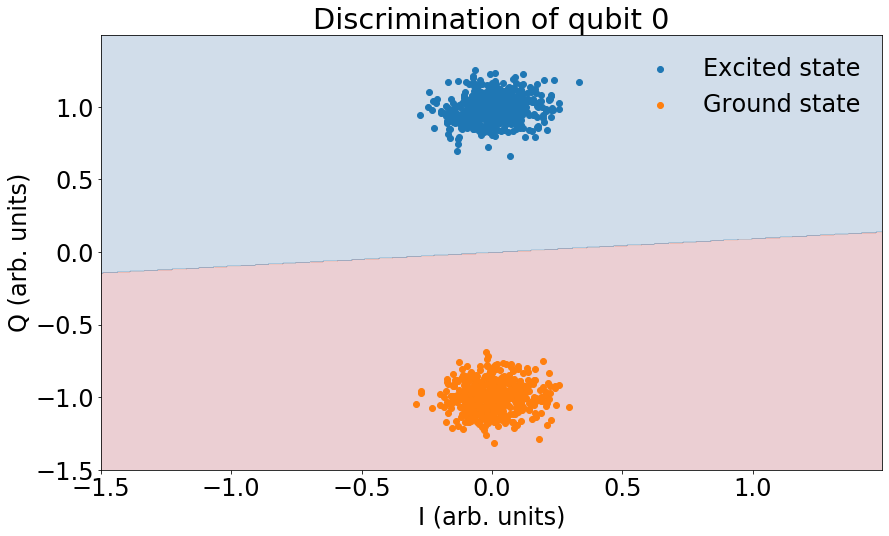

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(14,8))
ax.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=.2)
plt.scatter(np.real(excited_shots[:, 0]), np.imag(excited_shots[:, 0]), label='Excited state')
plt.scatter(np.real(ground_shots[:, 0]), np.imag(ground_shots[:, 0]), label='Ground state')
plt.legend(frameon=False)
plt.xlabel('I (arb. units)')
plt.ylabel('Q (arb. units)')
plt.title('Discrimination of qubit {}'.format(qubit));